## Import librairies

In [51]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


from sklearn.model_selection import validation_curve


# Tree print
from sklearn.tree import export_graphviz

# warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  #hide any pandas warnings

sns.set(style="whitegrid", color_codes=True)

In [2]:
# Define confusion matrix function
def do_confusion_matrix(Y, prediction):
    cm = confusion_matrix(Y, prediction)
    cm_df = pd.DataFrame(cm, index=["True", "False"], columns=["Positive", "Negative"])
    sns.heatmap(cm_df, annot=True, square=True, cmap="YlGnBu")
    plt.tight_layout()
    plt.show()
    print("Sensitivity (True Positives Rate):", np.round(cm[0,0]/(cm[0,0] + cm[1,1]), 2))
    print("Specificity (True Negatives Rate):", np.round(cm[0,1]/(cm[0,1] + cm[1,0]), 2))
    
# Define feature importance function
def do_feature_importance(model, x, y):
    model.fit(x, y)
    feature_importance = pd.DataFrame(model.feature_importances_, index=x.columns, columns=['RFC']).sort_values('RFC', ascending=False)

    sns.barplot(x=feature_importance.values[:,0], y=feature_importance.index, palette="deep")
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.show()
    model = None

## Read Dataset

In [3]:
# Read data
file_name = 'heart.csv'
ds = pd.read_csv(file_name)

# Drop rows with thal equal to 0
ds.drop(ds[ds['thal'] == 0].index, axis=0, inplace=True)

## Rename of columns and type conversion

In [4]:
# Columns rename
ds.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

# Modifico i valori in modo da identificare con chiarezza le
# feature categoriche
ds['sex'][ds['sex'] == 0] = 'female'
ds['sex'][ds['sex'] == 1] = 'male'

ds['chest_pain_type'][ds['chest_pain_type'] == 0] = 'typical angina'
ds['chest_pain_type'][ds['chest_pain_type'] == 1] = 'atypical angina'
ds['chest_pain_type'][ds['chest_pain_type'] == 2] = 'non-anginal pain'
ds['chest_pain_type'][ds['chest_pain_type'] == 3] = 'asymptomatic'

ds['fasting_blood_sugar'][ds['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
ds['fasting_blood_sugar'][ds['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

ds['rest_ecg'][ds['rest_ecg'] == 0] = 'normal'
ds['rest_ecg'][ds['rest_ecg'] == 1] = 'ST-T wave abnormality'
ds['rest_ecg'][ds['rest_ecg'] == 2] = 'left ventricular hypertrophy'

ds['exercise_induced_angina'][ds['exercise_induced_angina'] == 0] = 'no'
ds['exercise_induced_angina'][ds['exercise_induced_angina'] == 1] = 'yes'

ds['st_slope'][ds['st_slope'] == 0] = 'upsloping'
ds['st_slope'][ds['st_slope'] == 1] = 'flat'
ds['st_slope'][ds['st_slope'] == 2] = 'downsloping'

ds['thalassemia'][ds['thalassemia'] == 1] = 'normal'
ds['thalassemia'][ds['thalassemia'] == 2] = 'fixed defect'
ds['thalassemia'][ds['thalassemia'] == 3] = 'reversable defect'


# Converto i tipi in modo corretto

ds['sex'] = ds['sex'].astype('object')
ds['chest_pain_type'] = ds['chest_pain_type'].astype('object')
ds['fasting_blood_sugar'] = ds['fasting_blood_sugar'].astype('object')
ds['rest_ecg'] = ds['rest_ecg'].astype('object')
ds['exercise_induced_angina'] = ds['exercise_induced_angina'].astype('object')
ds['st_slope'] = ds['st_slope'].astype('object')
ds['thalassemia'] = ds['thalassemia'].astype('object')

# Exploratory data analysis

In [5]:
# Dataset sample
ds.sample(10)

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
298,57,female,typical angina,140,241,lower than 120mg/ml,ST-T wave abnormality,123,yes,0.2,flat,0,reversable defect,0
141,43,male,typical angina,115,303,lower than 120mg/ml,ST-T wave abnormality,181,no,1.2,flat,0,fixed defect,1
80,41,male,non-anginal pain,112,250,lower than 120mg/ml,ST-T wave abnormality,179,no,0.0,downsloping,0,fixed defect,1
216,62,female,non-anginal pain,130,263,lower than 120mg/ml,ST-T wave abnormality,97,no,1.2,flat,1,reversable defect,0
161,55,female,atypical angina,132,342,lower than 120mg/ml,ST-T wave abnormality,166,no,1.2,downsloping,0,fixed defect,1
209,59,male,typical angina,140,177,lower than 120mg/ml,ST-T wave abnormality,162,yes,0.0,downsloping,1,reversable defect,0
211,61,male,typical angina,120,260,lower than 120mg/ml,ST-T wave abnormality,140,yes,3.6,flat,1,reversable defect,0
272,67,male,typical angina,120,237,lower than 120mg/ml,ST-T wave abnormality,71,no,1.0,flat,0,fixed defect,0
280,42,male,typical angina,136,315,lower than 120mg/ml,ST-T wave abnormality,125,yes,1.8,flat,0,normal,0
139,64,male,typical angina,128,263,lower than 120mg/ml,ST-T wave abnormality,105,yes,0.2,flat,1,reversable defect,1


In [6]:
# Shape of dataset
print("Rows:", ds.shape[0], "\nFeatures:", ds.shape[1])

Rows: 301 
Features: 14


## Correlation heatmap

Uso solo i dati numerici per ottenere una matrice di correlazione

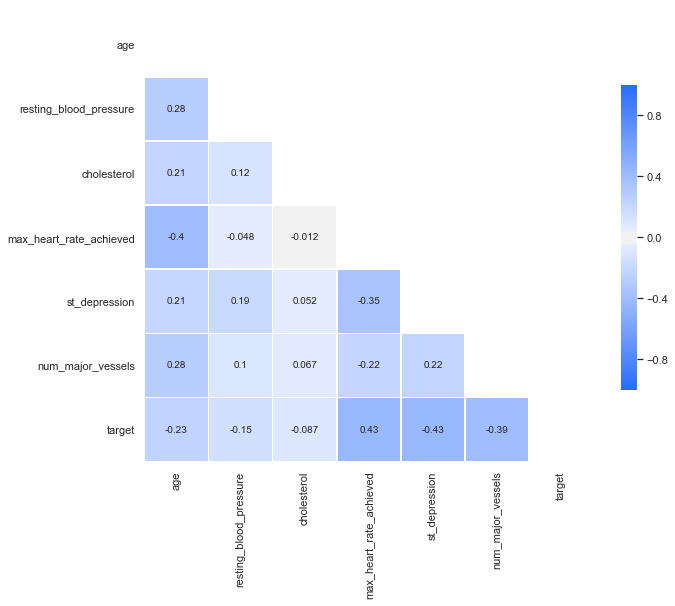

In [7]:
# Matrix Correlation Plot
corr = ds.corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
cmap = sns.diverging_palette(260, 260, s=100, l=50, n=9, as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-1, center=0, square=True, linewidth=.5, cbar_kws={'shrink': .5}, annot=True, mask=mask, cmap=cmap)
plt.tight_layout()
plt.show()

In [8]:
print("There are missing values?", ds.isnull().values.any(), "\n")
ds.info()

There are missing values? False 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 0 to 302
Data columns (total 14 columns):
age                        301 non-null int64
sex                        301 non-null object
chest_pain_type            301 non-null object
resting_blood_pressure     301 non-null int64
cholesterol                301 non-null int64
fasting_blood_sugar        301 non-null object
rest_ecg                   301 non-null object
max_heart_rate_achieved    301 non-null int64
exercise_induced_angina    301 non-null object
st_depression              301 non-null float64
st_slope                   301 non-null object
num_major_vessels          301 non-null int64
thalassemia                301 non-null object
target                     301 non-null int64
dtypes: float64(1), int64(6), object(7)
memory usage: 35.3+ KB


## Categorical features handling using dummy features

In [9]:
# Dummy features
ds = pd.get_dummies(ds, drop_first=True)

## Data distribution

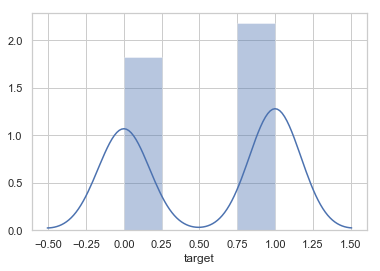

In [73]:
sns.distplot(ds["target"], hist=True)
plt.show()

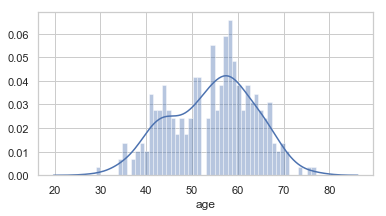

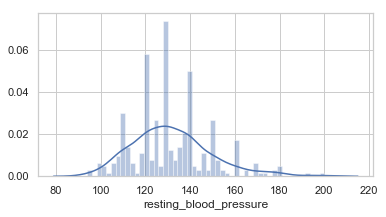

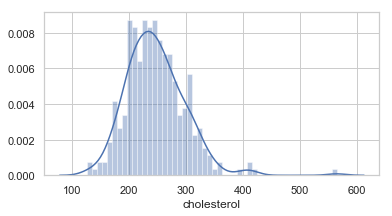

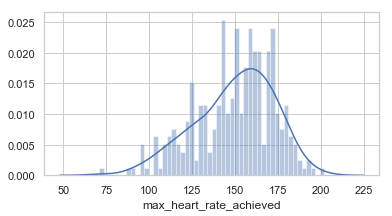

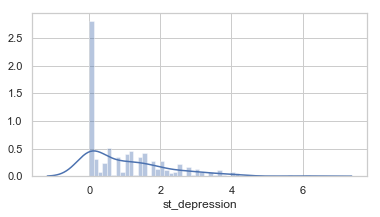

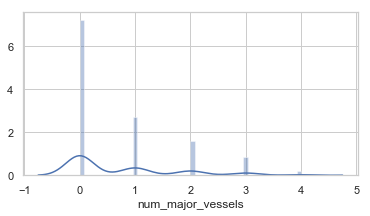

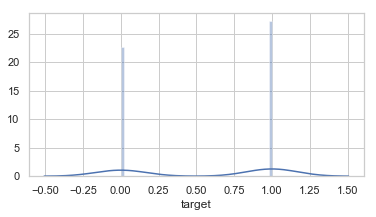

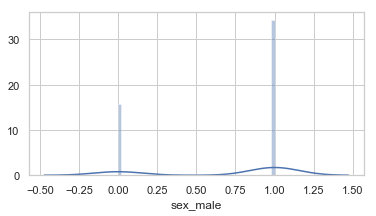

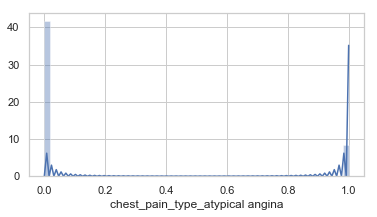

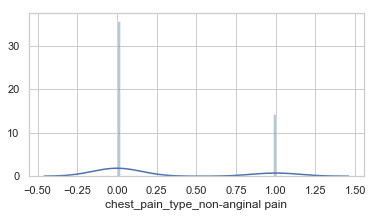

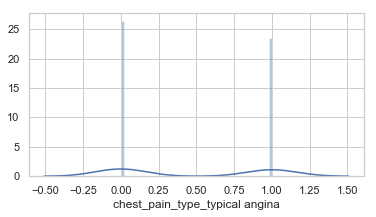

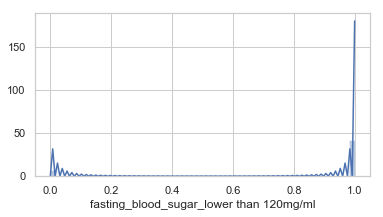

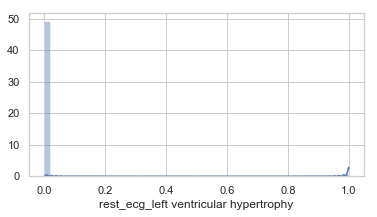

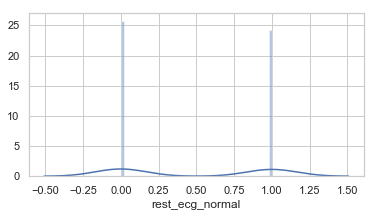

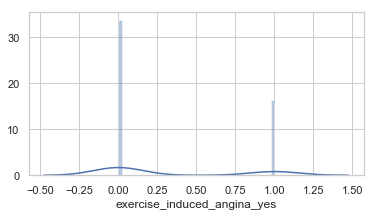

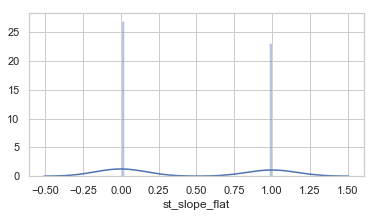

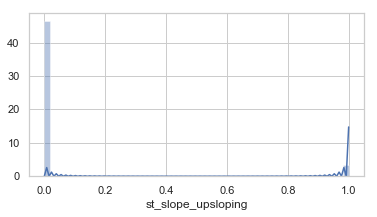

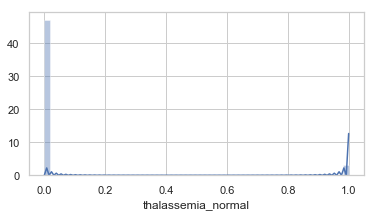

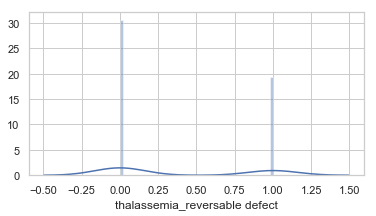

In [11]:
pd.set_option('display.max_columns', None)
ds.describe()

for c in ds.columns:
    plt.figure(figsize=(6, 3))
    sns.distplot(ds[c], hist=True, bins=50)
    plt.show()

# Model implementation and tuning

In [12]:
# Split data in dataset and values to predict
X = ds.drop(['target'], axis=1) # X -> data
Y = ds['target'] # Y -> values to predict

## Feature importance

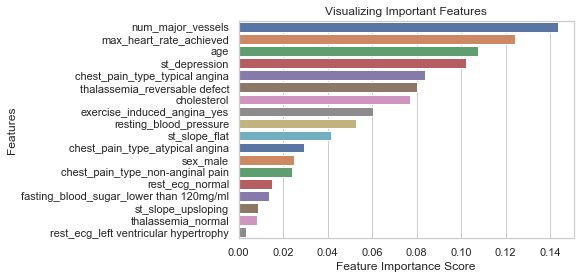

In [13]:
#Uso RFC per estrarre le features più importanti
model = RandomForestClassifier(random_state = 50)
do_feature_importance(model, X, Y)

## Data normalization

In [14]:
# Normalizzo i dati
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
columns_names = X.columns
# Fit your data on the scaler object
X_scaled = X
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=columns_names)
X_scaled.describe()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,thalassemia_normal,thalassemia_reversable defect
count,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,301.000000,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02
mean,8.262125e-17,2.950759e-16,3.835987e-17,-9.442428e-17,0.000000,-2.360607e-17,-2.360607e-17,1.180304e-17,4.721214e-17,9.442428e-17,-1.209811e-16,2.065531e-17,-1.239319e-16,-7.081821e-17,-2.360607e-17,6.491670e-17,5.901518e-18,2.360607e-17
std,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00
min,-2.790159e+00,-2.143374e+00,-2.325019e+00,-3.445541e+00,-0.898179,-7.180170e-01,-1.472556e+00,-4.463218e-01,-6.324555e-01,-9.450300e-01,-2.416797e+00,-1.160518e-01,-9.705336e-01,-6.948083e-01,-9.262962e-01,-2.738613e-01,-2.521988e-01,-7.974143e-01
25%,-8.112244e-01,-6.631372e-01,-6.850318e-01,-6.887884e-01,-0.898179,-7.180170e-01,-1.472556e+00,-4.463218e-01,-6.324555e-01,-9.450300e-01,4.137707e-01,-1.160518e-01,-9.705336e-01,-6.948083e-01,-9.262962e-01,-2.738613e-01,-2.521988e-01,-7.974143e-01
50%,1.782429e-01,-9.381519e-02,-1.062129e-01,1.426132e-01,-0.209384,-7.180170e-01,6.790913e-01,-4.463218e-01,-6.324555e-01,-9.450300e-01,4.137707e-01,-1.160518e-01,-9.705336e-01,-6.948083e-01,-9.262962e-01,-2.738613e-01,-2.521988e-01,-7.974143e-01
75%,7.279470e-01,4.755068e-01,5.497818e-01,7.114670e-01,0.479410,2.599157e-01,6.790913e-01,-4.463218e-01,1.581139e+00,1.058167e+00,4.137707e-01,-1.160518e-01,1.030361e+00,1.439246e+00,1.079568e+00,-2.738613e-01,-2.521988e-01,1.254053e+00
max,2.487000e+00,3.891439e+00,6.125737e+00,2.286754e+00,4.439978,3.193714e+00,6.790913e-01,2.240536e+00,1.581139e+00,1.058167e+00,4.137707e-01,8.616844e+00,1.030361e+00,1.439246e+00,1.079568e+00,3.651484e+00,3.965126e+00,1.254053e+00


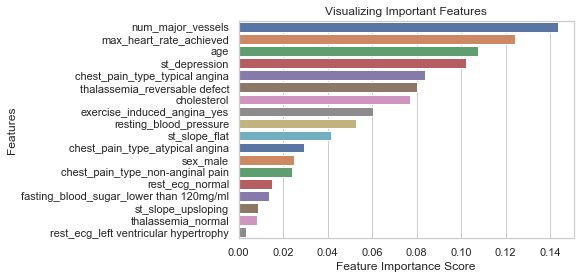

In [15]:
#Uso RFC per estrarre le features più importanti

model = RandomForestClassifier(random_state = 50)
do_feature_importance(model, X_scaled, Y)

## Train Set and Validation Set Split

In [37]:
# Split train set and test set (train: 75% test: 25%)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.25, random_state = 50)
print("Train set:", np.round(X_train.shape[0]/X.shape[0]*100), "%", "({}/{})".format(X_train.shape[0], X.shape[0]))
print("Test set:", np.round(X_test.shape[0]/X.shape[0]*100), "%", "({}/{})".format(X_test.shape[0], X.shape[0]))

Train set: 75.0 % (225/301)
Test set: 25.0 % (76/301)


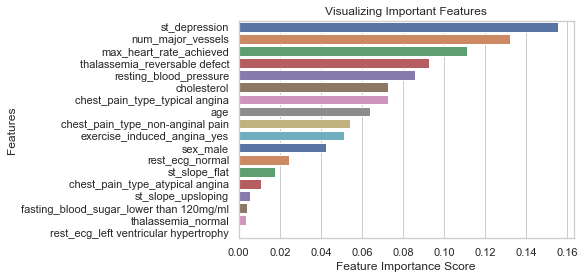

In [38]:
#Uso RFC per estrarre le features più importanti

model = RandomForestClassifier(random_state = 50)
do_feature_importance(model, X_train, Y_train)

The accuracy score on the testing set: 82.895 %


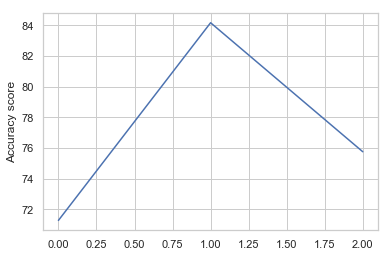

Accuracy CV: 77.06766666666665 %


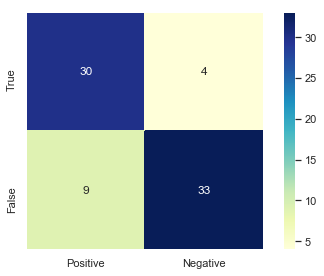

Sensitivity (True Positives Rate): 0.48
Specificity (True Negatives Rate): 0.31


In [39]:
# First attempt

model = RandomForestClassifier(random_state = 50)
model = model.fit(X_train, Y_train)
prediction = model.predict(X_test)
accuracy = accuracy_score(Y_test, prediction)
accuracy = np.round(accuracy * 100, 3)


print("The accuracy score on the testing set:", accuracy,"%")
model = None


model = RandomForestClassifier(random_state = 50)
#model = model.fit(X, Y_train)
accuracy = cross_val_score(model, X_scaled, Y, cv = 3, scoring = 'accuracy')
accuracy = np.round(accuracy * 100, 3)

model = None

plt.plot(accuracy, 'b', label="Training Acc")
plt.ylabel('Accuracy score')
plt.show()
print("Accuracy CV:", np.mean(accuracy), "%")

do_confusion_matrix(Y_test, prediction)



### Hyperparameters tuning using Cross Validation


In [43]:

def do_validation_curve(classifier, x, y, param_name, param_range):
    train_scores, test_scores = validation_curve(
                                    classifier,
                                    X=x, y=y, 
                                    param_name=param_name, 
                                    param_range=param_range,
                                    cv = 3)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 5))
    plt.title("Validation Curve with RFC")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.6, 1.1)
    lw = 1
    plt.plot(param_range, train_scores_mean,'.-', label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, '.-', label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    
    return test_scores_mean

In [44]:
# Definisco le liste di iperparametri
# n_estimators max_depth min_samples_split min_samples_leaf max_features

max_features = list(range(1,X_scaled.shape[1]))
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 300, 500, 750]
min_samples_leaf = [1, 2, 4, 8]
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bootstrap = [False, True]

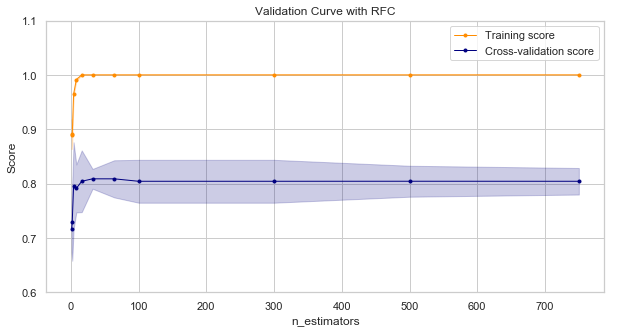

Best n_estimators: 32


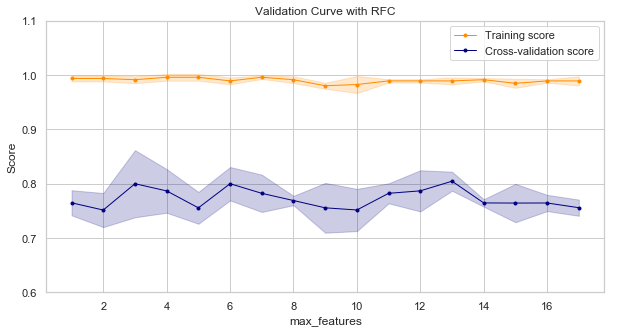

Best max_features: 13


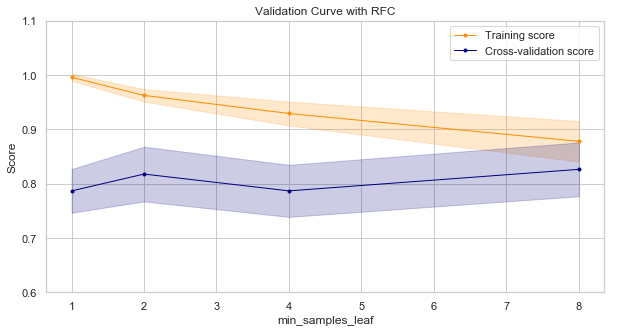

Best min_samples_leaf: 8


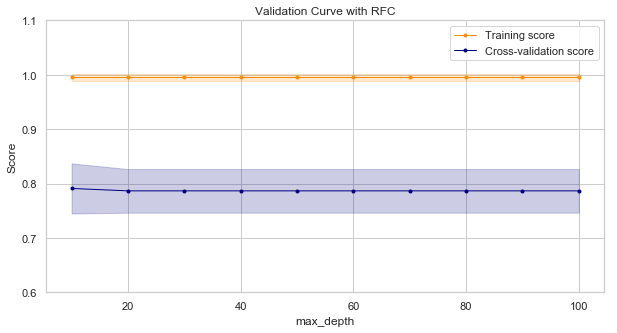

Best max_depth: 10


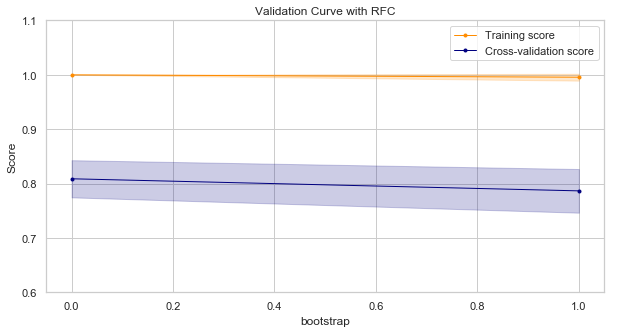

Best bootstrap: False


In [46]:
# Tuning n_estimators
test_scores_mean = do_validation_curve(RandomForestClassifier(random_state=50), X_train, Y_train, 'n_estimators', n_estimators)
print("Best n_estimators:", n_estimators[np.argmax(test_scores_mean)])

# Tuning max_features
test_scores_mean = do_validation_curve(RandomForestClassifier(random_state=50), X_train, Y_train, 'max_features', max_features)
print("Best max_features:", max_features[np.argmax(test_scores_mean)])

# Tuning min_samples_leaf
test_scores_mean = do_validation_curve(RandomForestClassifier(random_state=50), X_train, Y_train, 'min_samples_leaf', min_samples_leaf)
print("Best min_samples_leaf:", min_samples_leaf[np.argmax(test_scores_mean)])

# Tuning max_depth
test_scores_mean = do_validation_curve(RandomForestClassifier(random_state=50), X_train, Y_train, 'max_depth', max_depth)
print("Best max_depth:", max_depth[np.argmax(test_scores_mean)])

# Tuning bootstrap
test_scores_mean = do_validation_curve(RandomForestClassifier(random_state=50), X_train, Y_train, 'bootstrap', bootstrap)
print("Best bootstrap:", bootstrap[np.argmax(test_scores_mean)])

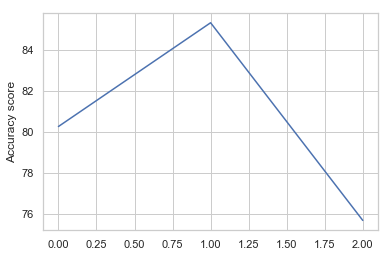

Cross Validation Accuracy Score: 80.424 %
The accuracy score on the testing set :  80.263 %


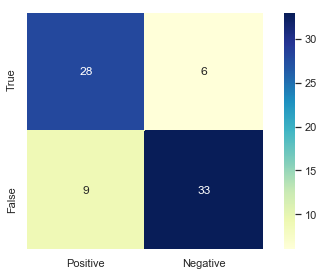

Sensitivity (True Positives Rate): 0.46
Specificity (True Negatives Rate): 0.4


In [48]:
# Cross Valdation Score
model = RandomForestClassifier(n_estimators=100, max_features=4, random_state = 50)
accuracy = cross_val_score(model, X_train, Y_train, cv = 3, scoring = 'accuracy')
accuracy = np.round(accuracy * 100, 3)
model = None

plt.plot(accuracy, 'b', label="Training Acc")
plt.ylabel('Accuracy score')
plt.show()
print("Cross Validation Accuracy Score:", np.round(np.mean(accuracy), 3), "%")

# Accuracy Score
model = RandomForestClassifier(n_estimators=100, max_features=4, random_state = 50)
model = model.fit(X_train, Y_train)
prediction = model.predict(X_test)
accuracy = accuracy_score(Y_test, prediction)
accuracy = np.round(accuracy * 100, 3)
print("The accuracy score on the testing set : ", accuracy,"%")

# Confusion Matrix
do_confusion_matrix(Y_test, prediction)

model = None

## Hyperparameter tuning using Test Set

In [41]:
def do_test_set_hyperparameter_tuning(x_train, x_test, y_train, y_test, param_name, param_range):
    train_results = []
    test_results = []
    for param in param_range:
        model = RandomForestClassifier(**{param_name: param, 'random_state': 50})
        model.fit(x_train, y_train)

        # Train prediction
        train_pred = model.predict(x_train)
        accuracy = accuracy_score(y_train, train_pred)
        train_results.append(accuracy)

        # Test prediction
        test_pred = model.predict(x_test)
        accuracy = accuracy_score(y_test, test_pred)
        test_results.append(accuracy)
        model = None

    plt.figure(figsize=(10, 5))
    plt.title("Accuracy")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.6, 1.1)
    lw = 1
    plt.plot(param_range, train_results,'.-', label="Training score",
                 color="darkorange", lw=lw)
    plt.plot(param_range, test_results, '.-', label="Test score",
                 color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    print("Max Test Score:", np.round(np.max(test_results)*100, 3))
    print("Best Param Value:", param_range[np.argmax(test_results)])

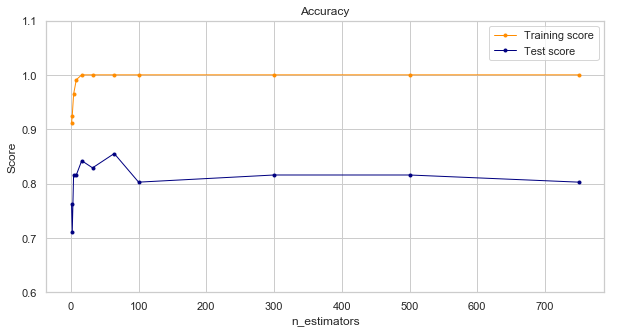

Max Test Score: 85.526
Best Param Value: 64


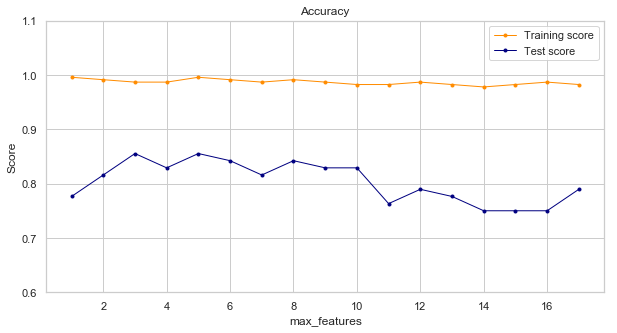

Max Test Score: 85.526
Best Param Value: 3


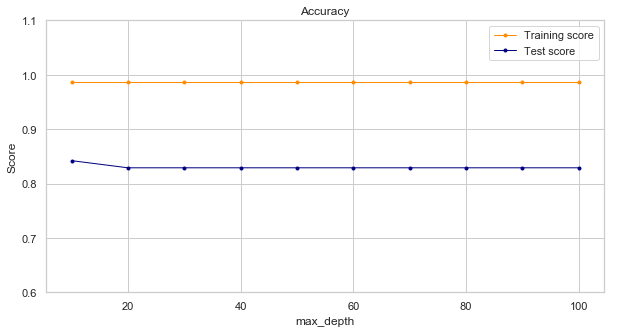

Max Test Score: 84.211
Best Param Value: 10


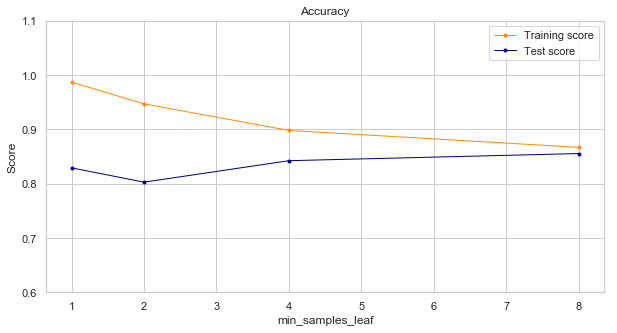

Max Test Score: 85.526
Best Param Value: 8


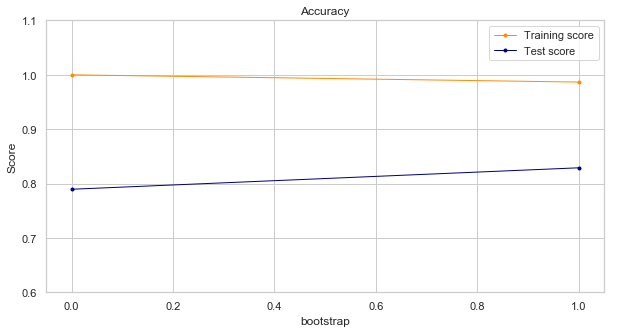

Max Test Score: 82.895
Best Param Value: True


In [42]:
#max_features = list(range(1,X_scaled.shape[1]))
#n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 300, 500, 750, 900, 1200]
#min_samples_leaf = [1, 2, 4, 8]
#max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#bootstrap = [False, True]

do_test_set_hyperparameter_tuning(X_train, X_test, Y_train, Y_test, "n_estimators", n_estimators)
do_test_set_hyperparameter_tuning(X_train, X_test, Y_train, Y_test, "max_features", max_features)
do_test_set_hyperparameter_tuning(X_train, X_test, Y_train, Y_test, "max_depth", max_depth)
do_test_set_hyperparameter_tuning(X_train, X_test, Y_train, Y_test, "min_samples_leaf", min_samples_leaf)
do_test_set_hyperparameter_tuning(X_train, X_test, Y_train, Y_test, "bootstrap", bootstrap)

## Model performance after TestSet Accuracy tuning

Test Set (without Hyperparameter tuning)
Accuracy on Test Set (without Hyperparameter tuning): 82.895 %


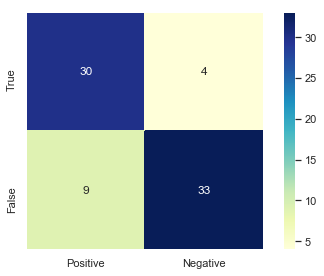

Sensitivity (True Positives Rate): 0.48
Specificity (True Negatives Rate): 0.31

**************************************************



Cross Validation on whole Dataset (without Hyperparameter tuning)


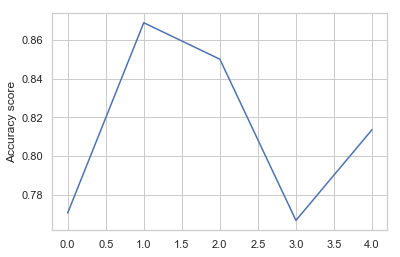

Accuracy CV: 81.391 %

**************************************************



Test Set (with Hyperparameter tuning)
Accuracy on Test Set (with Hyperparameter tuning): 82.895 %


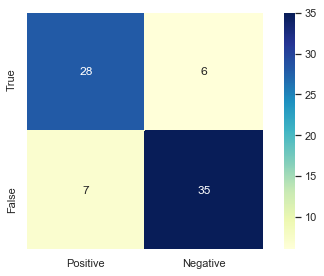

Sensitivity (True Positives Rate): 0.44
Specificity (True Negatives Rate): 0.46

**************************************************



Cross Validation on whole Dataset


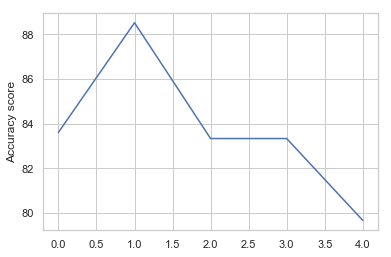

Accuracy CV: 83.692 %

**************************************************



Cross Validation on Train Set


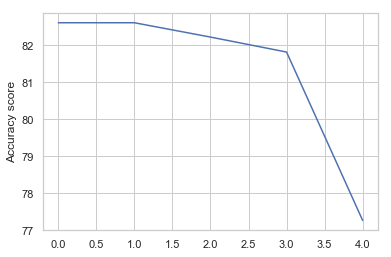

Accuracy CV: 81.306 %

**************************************************





In [44]:
# Test Set accuracy without Hyperparameter tuning
model = RandomForestClassifier(random_state=50)
model.fit(X_train, Y_train)

test_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, test_pred)
print("Test Set (without Hyperparameter tuning)")
print("Accuracy on Test Set (without Hyperparameter tuning):", np.round(accuracy*100, 3), "%")
do_confusion_matrix(Y_test, test_pred)
print()
print("*"*50)
print("\n\n")
model = None

model = RandomForestClassifier(random_state=50)
accuracy = cross_val_score(model, X_scaled, Y, cv = 5, scoring = 'accuracy')
print("Cross Validation on whole Dataset (without Hyperparameter tuning)")
plt.plot(accuracy, 'b', label="Accuracy CV")
plt.ylabel('Accuracy score')
plt.show()
print("Accuracy CV:", np.round(100*np.mean(accuracy), 3), "%")
print()
print("*"*50)
print("\n\n")
model = None



# Test Set Accuracy with Hyperparameter tuning
model = RandomForestClassifier(random_state=50, n_estimators=100, max_features=3, min_samples_leaf=4, bootstrap=False)
model.fit(X_train, Y_train)

test_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, test_pred)
print("Test Set (with Hyperparameter tuning)")
print("Accuracy on Test Set (with Hyperparameter tuning):", np.round(accuracy*100, 3), "%")
do_confusion_matrix(Y_test, test_pred)
print()
print("*"*50)
print("\n\n")

# Whole Dataset with Cross Validation and Hyperparameter tuning
#model = RandomForestClassifier(random_state=50, n_estimators=100, max_features=3, min_samples_leaf=4)
model = None
model = RandomForestClassifier(random_state=50, n_estimators=100, max_features=3, min_samples_leaf=4, bootstrap=False)
accuracy = cross_val_score(model, X_scaled, Y, cv = 5, scoring = 'accuracy')
accuracy = np.round(accuracy * 100, 3)

print("Cross Validation on whole Dataset")
plt.plot(accuracy, 'b', label="Accuracy CV")
plt.ylabel('Accuracy score')
plt.show()
print("Accuracy CV:", np.round(np.mean(accuracy), 3), "%")
print()
print("*"*50)
print("\n\n")


# Train Set with Cross Validation and Hyperparameter tuning
model = None
model = RandomForestClassifier(random_state=50, n_estimators=100, max_features=3, min_samples_leaf=4, bootstrap=False)
accuracy = cross_val_score(model, X_train, Y_train, cv = 5, scoring = 'accuracy')
accuracy = np.round(accuracy * 100, 3)

print("Cross Validation on Train Set")
plt.plot(accuracy, 'b', label="Accuracy CV")
plt.ylabel('Accuracy score')
plt.show()
print("Accuracy CV:", np.round(np.mean(accuracy), 3), "%")
print()
print("*"*50)
print("\n\n")
model = None

## Decision Tree print

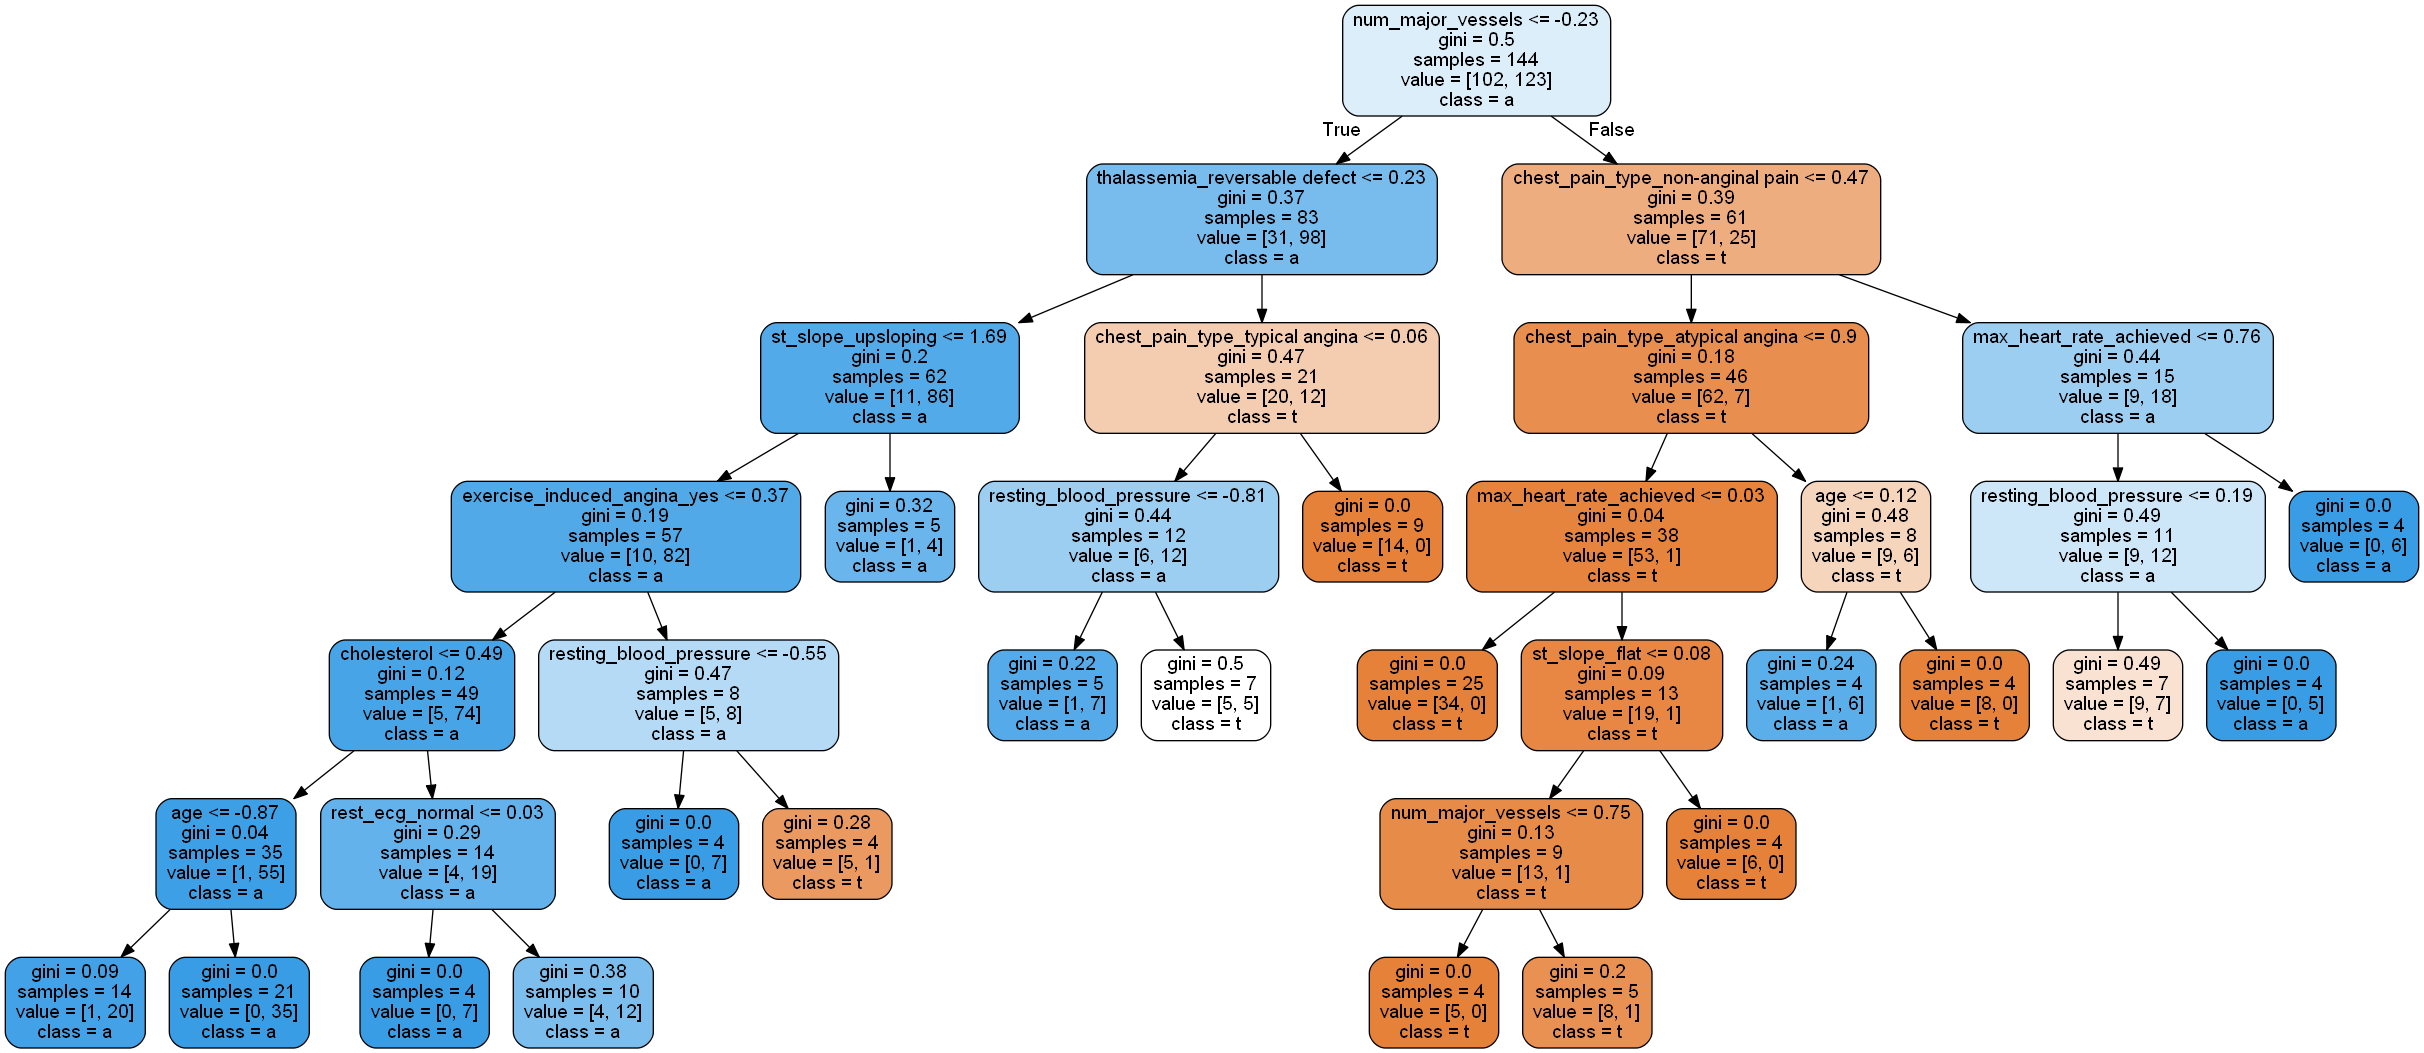

In [25]:
model = RandomForestClassifier(random_state=50, n_estimators=100, max_features=3, min_samples_leaf=4)
model.fit(X_train, Y_train)
estimator = model.estimators_[5]
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = columns_names,
                class_names = "target",
                rounded = True, proportion = False, 
                precision = 2, filled = True)
model = None

import pydot
(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

## Tuning with annidate loops

In [30]:
#max_features = list(range(1,X_scaled.shape[1]))
max_features = list(range(2,17))
n_estimators = [2, 4, 8, 16, 32, 64, 100, 300, 500]
bootstrap = [False, True]
accuracy_arr = np.zeros(len(max_features)*len(n_estimators)*len(bootstrap))
tot = len(max_features)*len(n_estimators)*len(bootstrap)*30
i = 0
# Itero k volte per ogni combinazione, ad ogni combinazione vengo quindi ad avere 5 misure, facendo la media delle 5
# ottengo un valore più preciso
for k in range(0,30):
    x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.25)
    j = -1
    for estimator in n_estimators:
        for max_f in max_features:
            for boot in bootstrap:
                j += 1
                model = RandomForestClassifier(n_estimators=estimator, max_features=max_f)
                model.fit(x_train, y_train)
                test_pred = model.predict(x_test)
                accuracy = accuracy_score(y_test, test_pred)
                accuracy_arr[j] = accuracy_arr[j] + accuracy/30
                model = None

                print("{}%".format(np.round(i/tot*100, 2)), end="\r")
                i += 1       

Best accuracy: [0.71256831 0.70273224 0.68196721 0.71256831 0.72131148 0.71256831
 0.72459016 0.70819672 0.71256831 0.69071038 0.72459016 0.73442623
 0.72786885 0.72459016 0.71803279 0.75409836 0.7715847  0.7726776
 0.7704918  0.76065574 0.78032787 0.77923497 0.7442623  0.74098361
 0.74754098 0.7715847  0.73333333 0.77377049 0.7704918  0.76393443
 0.80218579 0.79344262 0.79781421 0.78688525 0.78579235 0.79781421
 0.78142077 0.78251366 0.78688525 0.78907104 0.78142077 0.79453552
 0.78251366 0.8010929  0.79016393 0.80765027 0.80546448 0.81420765
 0.81202186 0.79562842 0.79672131 0.80546448 0.80655738 0.80327869
 0.80437158 0.80983607 0.79562842 0.80437158 0.79672131 0.79672131
 0.81967213 0.83606557 0.8273224  0.83387978 0.82513661 0.82185792
 0.81857923 0.81420765 0.81530055 0.81420765 0.81530055 0.81530055
 0.80765027 0.81311475 0.80765027 0.82622951 0.83825137 0.83825137
 0.8284153  0.82622951 0.81311475 0.8273224  0.81967213 0.82076503
 0.82295082 0.81748634 0.81530055 0.80874317 0.8

In [47]:
accuracy_best = 0
n_estimators_best = 0
max_features_best = 0
bootstrap_best = False

j = -1
for estimator in n_estimators:
    for max_f in max_features:
        for bott in bootstrap:
            j += 1
            if accuracy_arr[j] > accuracy_best:
                accuracy_best = accuracy_arr[j]
                n_estimators_best = estimator
                max_features_best = max_f
                bootstrap_best = boot
            

print("Best accuracy:", accuracy_best)
print("Best n_estimators:", n_estimators_best)
print("Best max_features:", max_features_best)
print("Best bootstrap:", bootstrap_best)

Best accuracy: 0.8437158469945354
Best n_estimators: 100
Best max_features: 3


In [50]:
model = RandomForestClassifier(n_estimators=100, max_features=3, random_state=50)
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
accuracy = accuracy_score(Y_test, prediction)
print("Accuracy:", np.round(accuracy*100, 3), "%")
model = None

Accuracy: 85.246 %


In [63]:
model = RandomForestClassifier(n_estimators=100, max_features=3, random_state=50)
accuracy = cross_val_score(model, X_train, Y_train, cv = 3, scoring = 'accuracy')
accuracy = np.mean(accuracy)
print("Accuracy:", np.round(accuracy*100, 3), "%")
model = None

Accuracy: 81.667 %


In [65]:
model = RandomForestClassifier(random_state=50)
accuracy = cross_val_score(model, X_train, Y_train, cv = 3, scoring = 'accuracy')
accuracy = np.mean(accuracy)
print("Accuracy:", np.round(accuracy*100, 3), "%")
model = None

Accuracy: 80.417 %


## Hyperparameter Tuning using exaustive GridSearch

In [21]:
max_features = list(range(2,17))
n_estimators = [2, 4, 8, 16, 32, 64, 100, 300, 500]

hyperF = dict(n_estimators=n_estimators, max_features=max_features)

gridF = GridSearchCV(RandomForestClassifier(), hyperF, cv = 3, verbose = 1, n_jobs = -1)
bestF = gridF.fit(X_train, Y_train)


Fitting 3 folds for each of 135 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 398 out of 405 | elapsed:   29.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   30.5s finished


In [23]:
accuracyCV = cross_val_score(bestF, X_train, Y_train)
bestF.best_estimator_

Fitting 3 folds for each of 135 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 235 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 398 out of 405 | elapsed:   23.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   25.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 135 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done 291 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 398 out of 405 | elapsed:   23.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   24.5s finished


Fitting 3 folds for each of 135 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   24.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=32, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
model = RandomForestClassifier()
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
accuracy = accuracy_score(Y_test, prediction)
print(accuracy)

#prediction_test = bestF.predict(X_test)
model = RandomForestClassifier(n_estimators=32, max_features=2)
model.fit(X_train, Y_train)
prediction_test = bestF.predict(X_test)
accuracy = accuracy_score(Y_test, prediction_test)
print(accuracy)

0.8421052631578947
0.8289473684210527


# Procedura finale di creazione modello
1. Divido in train set e validation set
2. Valuto un modello usando train e test senza tuning e mettendo anche Confusion Matrix
3. Uso GridSearch che tuna gli Hyperparameters contemporaneamente usando la cross validation
4. Creo un modello con gli iperparametri tunati
5. Faccio una predizion e la valido con il test set

#### Train Set, Test Set Split

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.25, random_state = 50)
print("Train set:", np.round(X_train.shape[0]/X.shape[0]*100), "%", "({}/{})".format(X_train.shape[0], X.shape[0]))
print("Test set:", np.round(X_test.shape[0]/X.shape[0]*100), "%", "({}/{})".format(X_test.shape[0], X.shape[0]))

Train set: 75.0 % (225/301)
Test set: 25.0 % (76/301)


#### Valuto un modello iniziale senza tuning degli hyperparametri

Accuracy Score (without Hyperparameters Tuning): 82.895%


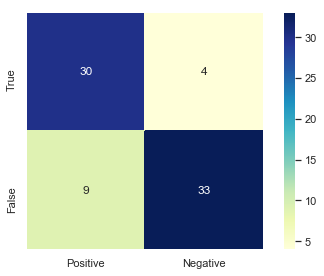

Sensitivity (True Positives Rate): 0.48
Specificity (True Negatives Rate): 0.31


In [66]:
model = RandomForestClassifier(random_state=50)
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
accuracy = accuracy_score(Y_test, prediction)
print("Accuracy Score (without Hyperparameters Tuning):", "{}%".format(np.round(100*accuracy,3)))
do_confusion_matrix(Y_test, prediction)

model = None
prediction = None
accuracy = None

#### Uso GridSearch con Cross Validation per il tuning degli Hyperparameters

##### Hyperparameters

In [62]:
max_features = list(range(1,X_scaled.shape[1]))
n_estimators = [2, 4, 8, 16, 32, 64, 100, 300, 500]
min_samples_leaf = [1, 2, 3, 4]
max_depth = [10, 20, 30, 40]
bootstrap = [False, True]

hyperF = dict(n_estimators=n_estimators,
              max_depth=max_depth,  
              max_features=max_features, 
              min_samples_leaf=min_samples_leaf,
              bootstrap=bootstrap)

##### Exhaustive Grid Search (cv=10)

In [64]:
gridF = GridSearchCV(RandomForestClassifier(random_state=50), hyperF, cv = 10, verbose = 1, n_jobs = -1)
bestF = gridF.fit(X_train, Y_train)

Fitting 10 folds for each of 12240 candidates, totalling 122400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2077 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 3406 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5115 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 7023 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 9329 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 11670 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 14325 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 17237 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 20880 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 24387 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 28159 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 32300 task

##### GridSearch Model CV Accuracy

In [ ]:
accuracyCV = cross_val_score(bestF, X_train, Y_train, cv = 10, scoring = 'accuracy')
accuracy = np.round(accuracy * 100, 3)

print("Cross Validation on Train Set")
plt.plot(accuracy, 'b', label="Accuracy CV")
plt.ylabel('Accuracy score')
plt.show()
print("CV Mean Accuracy Score:", np.round(np.mean(accuracy), 3), "%")
print()
print("*"*50)
print("\n\n")

##### Creo un modello usando gli Hyperparametri trovati

Accuracy Score (with Hyperparameters Tuning): 85.526%


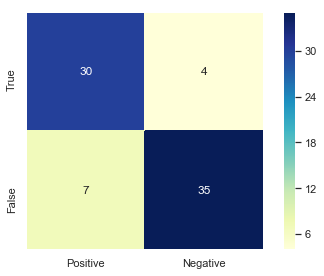

Sensitivity (True Positives Rate): 0.46
Specificity (True Negatives Rate): 0.36


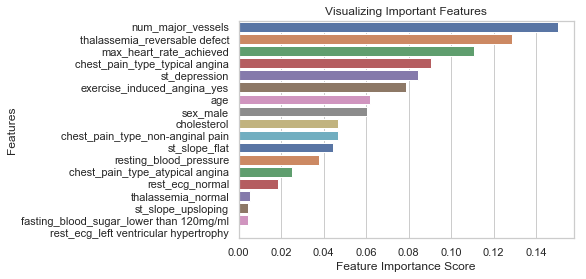

In [72]:
model = RandomForestClassifier(random_state=50, criterion='gini', n_estimators=bestF.best_estimator_.n_estimators,
              max_depth=bestF.best_estimator_.max_depth,  
              max_features=3, 
              min_samples_leaf=bestF.best_estimator_.min_samples_leaf,
              bootstrap=bestF.best_estimator_.bootstrap)
model = model.fit(X_train, Y_train)
prediction = model.predict(X_test)
accuracy = accuracy_score(Y_test, prediction)
print("Accuracy Score (with Hyperparameters Tuning):", "{}%".format(np.round(100*accuracy,3)))

do_confusion_matrix(Y_test, prediction)
do_feature_importance(RandomForestClassifier(random_state=50, n_estimators=bestF.best_estimator_.n_estimators,
              max_depth=bestF.best_estimator_.max_depth,  
              max_features=bestF.best_estimator_.max_features, 
              min_samples_leaf=bestF.best_estimator_.min_samples_leaf,
              bootstrap=bestF.best_estimator_.bootstrap),
                      X_scaled, Y)

model = None
prediction = None
accuracy = None


In [67]:
bestF.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=10, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=None,
            oob_score=False, random_state=50, verbose=0, warm_start=False)